In [154]:
import pandas as pd
import string
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandasql as sqldf
import numpy as np

### Initial Model

To start, we are going to capture accuracy of a simple baseline model that we can use to benchmark

What we want to do is to "clean" our data. In this instance, we have to convert categorical variables into one hot encodings

In [155]:
df_initial = pd.read_csv("data.csv", sep=";")
df_initial = df_initial.loc[df_initial["Target"] != "Enrolled"]
df_initial

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


For Categorical, nominal variables, we have to apply one-hot encodings

In [156]:
marital_encod = pd.get_dummies(df_initial["Marital status"], prefix="marital_status")
app_mode_encod = pd.get_dummies(df_initial["Application mode"], prefix="app_mode")
course_encod = pd.get_dummies(df_initial["Course"], prefix="course")
prev_qual_encod = pd.get_dummies(df_initial["Previous qualification"], prefix="previous_qualifcation")
nacion_encod = pd.get_dummies(df_initial["Nacionality"], prefix="Nacionality")
mothers_qual_encod = pd.get_dummies(df_initial["Mother's qualification"], prefix="mothers_qual")
fathers_qual_encod = pd.get_dummies(df_initial["Father's qualification"], prefix="fathers_qual")
mothers_occu_encod = pd.get_dummies(df_initial["Mother's occupation"], prefix="mothers_occu")
fathers_occu_encod = pd.get_dummies(df_initial["Father's occupation"], prefix="fathers_occu")

to_drop = ["Marital status", "Application mode", "Course", "Previous qualification", "Nacionality", "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation"]

trash_df_to_model = pd.concat([df_initial, marital_encod, app_mode_encod, course_encod, prev_qual_encod, nacion_encod, mothers_qual_encod, fathers_qual_encod, mothers_occu_encod, fathers_occu_encod],
                              axis=1)
trash_df_to_model = trash_df_to_model.drop(to_drop, axis=1)             
trash_df_to_model['Target'] = trash_df_to_model['Target'].map({'Graduate': 1, 'Dropout': 0})
# normalizing
trash_df_to_model = (trash_df_to_model - trash_df_to_model.min()) / (trash_df_to_model.max() - trash_df_to_model.min())
trash_df_to_model['Target'] = trash_df_to_model['Target'].map({1.0: 1, 0.0: 0})
trash_df_to_model

,Application order,Daytime/evening attendance\t,Previous qualification (grade),Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,...,fathers_occu_172,fathers_occu_174,fathers_occu_175,fathers_occu_181,fathers_occu_182,fathers_occu_183,fathers_occu_192,fathers_occu_193,fathers_occu_194,fathers_occu_195
0,0.833333,1.0,0.284211,0.340000,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.166667,1.0,0.684211,0.500000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.833333,1.0,0.284211,0.313684,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333333,1.0,0.284211,0.258947,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.166667,0.0,0.052632,0.489474,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1.000000,1.0,0.315789,0.286316,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4420,0.333333,1.0,0.263158,0.252632,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4421,0.166667,1.0,0.621053,0.573684,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4422,0.166667,1.0,0.894737,0.618947,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From here, we can model everything

In [157]:
df_initial_mod_2 = df_initial[:]
df_initial_mod_2['Target'] = df_initial_mod_2['Target'].map({'Graduate': 1, 'Dropout': 0})
# 5 splits for 80-20
kf_optimal_finder = KFold(n_splits=5, shuffle=True, random_state=2)  # group 2 random state

# we do k-fold cross validation with the Bernoulli Naive Bayes, Decision Tree, and a Random Forest
temp_naive_bayes = BernoulliNB()
temp_tree = DecisionTreeClassifier(random_state=2)
temp_forest = RandomForestClassifier(random_state=2)

# generating accuracy scores and f1 scores
nb_accs = []
dt_accs = []
rf_accs = []

nb_f1s = []
dt_f1s = []
rf_f1s = []

# and getting depths for the tree and forest
dt_depths = []
rf_depths = []

x_vals = df_initial_mod_2.drop("Target", axis=1)
y_vals = df_initial_mod_2["Target"]


for train_index, test_index in kf_optimal_finder.split(x_vals):
    # establishing training and testing sets
    x_train, x_test = x_vals.iloc[train_index], x_vals.iloc[test_index]
    y_train, y_test = y_vals.iloc[train_index], y_vals.iloc[test_index]

    # From here, we can now fit the models
    temp_naive_bayes.fit(x_train, y_train)
    temp_tree.fit(x_train, y_train)
    temp_forest.fit(x_train, y_train)

    # make the predictions
    nb_predictions = temp_naive_bayes.predict(x_test)
    dt_predictions = temp_tree.predict(x_test)
    rf_predictions = temp_forest.predict(x_test)

    # gather accuracies
    nb_acc = accuracy_score(y_test, nb_predictions)
    nb_accs.append(nb_acc)

    dt_acc = accuracy_score(y_test, dt_predictions)
    dt_accs.append(dt_acc)

    rf_acc = accuracy_score(y_test, rf_predictions)
    rf_accs.append(rf_acc)

    # gather f1 scores
    nb_f1 = f1_score(y_test, nb_predictions)
    nb_f1s.append(nb_f1)

    dt_f1 = f1_score(y_test, dt_predictions)
    dt_f1s.append(dt_f1)

    rf_f1 = f1_score(y_test, rf_predictions)
    rf_f1s.append(rf_f1)

    # gathering depths
    dt_depths.append(temp_tree.get_depth())
    all_depths = [estimator.tree_.max_depth for estimator in temp_forest.estimators_]
    rf_depths.append(max(all_depths))

# printing out results for reproducibility
print("NAIVE BAYES")
print("ACCURACY LIST: ", nb_accs)
print("AVERAGE ACCURACY SCORE:", sum(nb_accs) / len(nb_accs))
print("F1 LIST:", nb_f1s)
print("AVERAGE F1 SCORE:", sum(nb_f1s) / len(nb_f1s))
print("----------------------------------")
print("DECISION TREE")
print("ACCURACY LIST:", dt_accs)
print("AVERAGE ACCURACY SCORE:", sum(dt_accs) / len(dt_accs))
print("F1 LIST:", dt_f1s)
print("AVERAGE F1 SCORE:", sum(dt_f1s) / len(dt_f1s))
print("DEPTHS LIST:", dt_depths)
print("AVERAGE DEPTH:", sum(dt_depths) / len(dt_depths))
print("----------------------------------")
print("RANDOM FOREST")
print("ACCURACY LIST: ", rf_accs)
print("AVERAGE ACCURACY SCORE:", sum(rf_accs) / len(rf_accs))
print("F1 LIST:", rf_f1s)
print("AVERAGE F1 SCORE:", sum(rf_f1s) / len(rf_f1s))
print("DEPTHS LIST:", rf_depths)
print("AVERAGE DEPTH:", sum(rf_depths) / len(rf_depths))
print("----------------------------------")

NAIVE BAYES
ACCURACY LIST:  [0.837465564738292, 0.8402203856749312, 0.8292011019283747, 0.8250688705234159, 0.8484848484848485]
AVERAGE ACCURACY SCORE: 0.8360881542699724
F1 LIST: [0.878099173553719, 0.8796680497925311, 0.8742393509127788, 0.8672936259143156, 0.8846960167714885]
AVERAGE F1 SCORE: 0.8767992433889666
----------------------------------
DECISION TREE
ACCURACY LIST: [0.8677685950413223, 0.837465564738292, 0.837465564738292, 0.8608815426997245, 0.8512396694214877]
AVERAGE ACCURACY SCORE: 0.8509641873278238
F1 LIST: [0.8906605922551253, 0.867117117117117, 0.8668171557562075, 0.8832369942196533, 0.8755760368663594]
AVERAGE F1 SCORE: 0.8766815792428926
DEPTHS LIST: [26, 24, 26, 22, 29]
AVERAGE DEPTH: 25.4
----------------------------------
RANDOM FOREST
ACCURACY LIST:  [0.9228650137741047, 0.8870523415977961, 0.9008264462809917, 0.9159779614325069, 0.9104683195592287]
AVERAGE ACCURACY SCORE: 0.9074380165289255
F1 LIST: [0.9387308533916849, 0.9108695652173915, 0.9224137931034484

### Data Analysis

There are a few variables that appear to be significant, and a few variables that are insignificant. This notebook is showing the key variables to consider. First, let's the rate of dropouts and graduations

In [158]:
num_grad = df_initial["Target"].value_counts()["Graduate"]
print("Number of students", df_initial.shape[0])
print("Number of graduates", num_grad)
print("% of graduates", num_grad / df_initial.shape[0] * 100)
df_initial["for_counting"] = 1  # for our analysis

Number of students 3630
Number of graduates 2209
% of graduates 60.85399449035813


Surprisingly, ~39% of students drop out - huge in terms of revenue

### Data Analysis - Dropping variables

To continue, we are going to consider variables to remove. That is, if there is low frequency of students within a variable, or the split of graduates-to-droputs is 50-50, we ideally want to remove those variables as those variables may not be helpful to the model's direction. Already having done pre-emptive analysis our analysis, we can consider Nacionality, Special Needs, International students to be dropped. These are variables may be dropped to suggest, to the human eye, that there may not be sufficient evidence to state that there is signficance between the categories in the variable

In [159]:
def provide_stacked_bar_individual(categorical_var, fn_df):
    """
    (str, DataFrame) -> plt.show() Object, pandas.DataFrame

    Provided a string, this function shows the distribution of a
    specified categorical variable, and the 
    Target (e.g. graduate or drop-out). This is to help with outputting a distribution
    """
    # getting unique categories
    x_categories = fn_df[categorical_var].unique()  # for the x axis
    stacked = fn_df["Target"].unique()

    # creating a pivot table to aggregate counts
    pivot_table = fn_df.pivot_table(index=categorical_var, columns="Target", aggfunc='size', fill_value=0)

    # plotting
    fig, ax = plt.subplots()

    # position of each bar on the x-axis
    x = np.arange(len(x_categories))
    # creating stacked bars for each stacked categories
    bottom = np.zeros(len(x_categories))
    for stacked_category in stacked:
        vals_temp = pivot_table[stacked_category].values
        ax.bar(x, vals_temp, bottom=bottom, label=stacked_category)
        bottom += vals_temp
    ax.set_xticks(x)
    ax.set_xticklabels(x_categories)
    ax.set_xlabel(categorical_var)
    ax.set_ylabel("Number of Students")
    ax.legend()
    return plt.show(), pivot_table


On Nacionality:

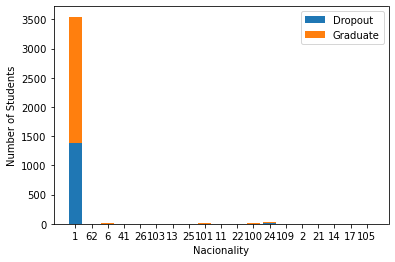

Target,Dropout,Graduate,pct graduate,pct dropout
Nacionality,,,,
1,1389,2155,0.608070,0.391930
2,0,2,1.000000,0.000000
6,4,4,0.500000,0.500000
11,0,3,1.000000,0.000000
13,0,1,1.000000,0.000000
14,0,1,1.000000,0.000000
17,1,0,0.000000,1.000000
21,1,0,0.000000,1.000000
22,4,8,0.666667,0.333333


In [160]:
plot_temp, df_temp = provide_stacked_bar_individual("Nacionality", df_initial)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

On Special Needs

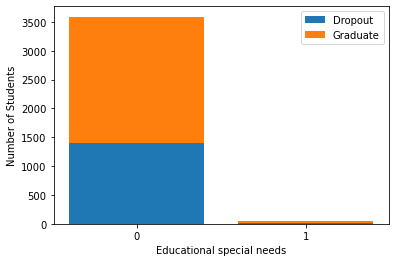

Target,Dropout,Graduate,pct graduate,pct dropout
Educational special needs,,,,
0,1404,2186,0.608914,0.391086
1,17,23,0.575000,0.425000


In [161]:
plot_temp, df_temp = provide_stacked_bar_individual("Educational special needs", df_initial)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

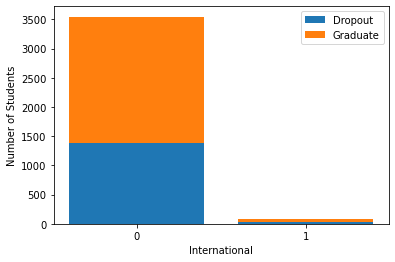

Target,Dropout,Graduate,pct graduate,pct dropout
International,,,,
0,1389,2155,0.608070,0.391930
1,32,54,0.627907,0.372093


In [162]:
plot_temp, df_temp = provide_stacked_bar_individual("International", df_initial)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

Thus, it should be sufficient for us to drop these variables as there may not be sufficient evidence to direct the model to an accurate prediction.

In [163]:
to_drop = ["Nacionality", "Educational special needs", "International"]
df_dropped = df_initial.drop(to_drop, axis=1)
df_dropped

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,for_counting
0,1,17,5,171,1,1,122.0,19,12,5,...,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
1,1,15,1,9254,1,1,160.0,1,3,3,...,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate,1
2,1,1,5,9070,1,1,122.0,37,37,9,...,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
3,1,17,2,9773,1,1,122.0,38,37,5,...,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate,1
4,2,39,1,8014,0,1,100.0,37,38,9,...,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,5,...,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate,1
4420,1,1,2,9773,1,1,120.0,1,1,9,...,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout,1
4421,1,1,1,9500,1,1,154.0,37,37,9,...,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout,1
4422,1,1,1,9147,1,1,180.0,37,37,7,...,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate,1


### Data Analysis - Variables to regroup

First is Application mode, this is how we organize them:

```
Ordinance
26 - Ordinance No. 533-A/99, item b2) (Different Plan) 
27 - Ordinance No. 533-A/99, item b3 (Other Institution) 
2 - Ordinance No. 612/93 
10 - Ordinance No. 854-B/99 15 - International student (bachelor) 

General Contingent
1 - 1st phase - general contingent
17 - 2nd phase - general contingent 
18 - 3rd phase - general contingent

Special Contingent
5 - 1st phase - special contingent (Azores Island) 
16 - 1st phase - special contingent (Madeira Island)


Diploma Holders
53 - Short cycle diploma holders 
44 - Technological specialization diploma holders 

Transfer / Change
57 - Change of institution/course (International)	
51 - Change of institution/course
43 - Change of course 
42 - Transfer 

Mature Students: 
7 - Holders of other higher courses 
39 - Over 23 years old 

In [164]:
# Stealing Jen's Method :)
# Define a function to map the values of application mode
def categorize_app_mode(app_mode_num):
    ordinance = {26, 27, 2, 10}
    g_cont = {1, 17, 18}
    special_cont = {5, 16}
    diploma = {53, 44}
    transfer_change = {57, 51, 43, 52}
    
    if app_mode_num in ordinance:
        return "Ordinance"
    elif app_mode_num in g_cont:
        return "General Contigent"
    elif app_mode_num in special_cont:
        return "Special Contengent"
    elif app_mode_num in diploma:
        return "Diploma Holders"
    else:
        return "Mature Students"  # Returning 0 for "Other" category

df_dropped['Application mode'] = df_dropped['Application mode'].apply(categorize_app_mode)
df_dropped

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,for_counting
0,1,General Contigent,5,171,1,1,122.0,19,12,5,...,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
1,1,Mature Students,1,9254,1,1,160.0,1,3,3,...,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate,1
2,1,General Contigent,5,9070,1,1,122.0,37,37,9,...,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
3,1,General Contigent,2,9773,1,1,122.0,38,37,5,...,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate,1
4,2,Mature Students,1,8014,0,1,100.0,37,38,9,...,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,General Contigent,6,9773,1,1,125.0,1,1,5,...,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate,1
4420,1,General Contigent,2,9773,1,1,120.0,1,1,9,...,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout,1
4421,1,General Contigent,1,9500,1,1,154.0,37,37,9,...,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout,1
4422,1,General Contigent,1,9147,1,1,180.0,37,37,7,...,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate,1


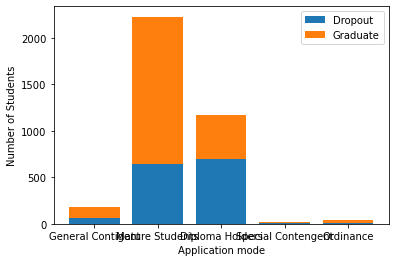

Target,Dropout,Graduate,pct graduate,pct dropout
Application mode,,,,
Diploma Holders,67,115,0.631868,0.368132
General Contigent,646,1583,0.710184,0.289816
Mature Students,694,472,0.404803,0.595197
Ordinance,7,8,0.533333,0.466667
Special Contengent,7,31,0.815789,0.184211


In [165]:
plot_temp, df_temp = provide_stacked_bar_individual("Application mode", df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

We do see a lot of variance between the percentages, so I would say that this is a keep (iffy-ist one is Ordinance)

Next is students' qualification the way we organize this is:

```
Secondary Education:
1 - Secondary education 

Higher education:
2 - Higher education - bachelor's degree 
3 - Higher education - degree
4 - Higher education - master's 
5 - Higher education - doctorate 
6 - Frequency of higher education 
40 - Higher education - degree (1st cycle)
43 - Higher education - master (2nd cycle)

Basic Education:
9 - 12th year of schooling - not completed 
10 - 11th year of schooling - not completed 
12 - Other - 11th year of schooling 
14 - 10th year of schooling 
15 - 10th year of schooling - not completed 
19 - Basic education 3rd cycle (9th/10th/11th year) or equiv. 
38 - Basic education 2nd cycle (6th/7th/8th year) or equiv. 

Vocational
39 - Technological specialization course 
42 - Professional higher technical course 


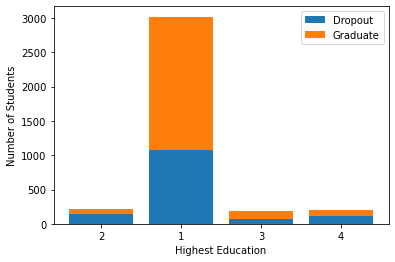

Target,Dropout,Graduate,pct graduate,pct dropout
Highest Education,,,,
1,149,63,0.297170,0.702830
2,1078,1941,0.642928,0.357072
3,75,117,0.609375,0.390625
4,119,88,0.425121,0.574879


In [166]:
# Define a function to map the values of "Previous quialification" to broader categories
def categorize_education(previous_qualification):
    secondary_edu = {1}
    higher_edu = {2, 3, 4, 5, 6, 40, 43}
    basic_edu = {9, 10, 12, 14, 15, 19, 38}
    vocational = {39, 42}

    # we're providing numbers as this can be ranked
    if previous_qualification in secondary_edu:
        return 2
    elif previous_qualification in higher_edu:
        return 4
    elif previous_qualification in basic_edu:
        return 1
    elif previous_qualification in vocational:
        return 3
    else:
        return 0  # Returning 0 for "Other" category

df_dropped['Highest Education'] = df_dropped['Previous qualification'].apply(categorize_education)
plot_temp, df_temp = provide_stacked_bar_individual("Highest Education", df_dropped)
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

Pretty good variance across the board - keep

In [167]:
if "Previous qualification" in df_dropped.columns:
    df_dropped = df_dropped.drop(["Previous qualification"], axis=1)
print(df_dropped.columns)

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification (grade)',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Debtor', 'Tuition fees up to date', 'Gender',
       'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       '

Lastly is going to be father's and mother's qualification. For mother's and father's qualification, we'll try one-hot encoding at the end. The way we group qualification is the following:

```
GROUPED (POST-SECONDARY) :
5 - Higher Education - Doctorate 
44 - Higher Education - Doctorate (3rd cycle)
4 - Higher Education - Master's 
43 - Higher Education - Master (2nd cycle) 
2 - Higher Education - Bachelor's Degree 
3 - Higher Education - Degree 
40 - Higher education - degree (1st cycle)


GROUPED (VOCATIONAL):
22 - Technical-professional course 
18 - General commerce course
39 - Technological specialization course 
41 - Specialized higher studies course 
42 - Professional higher technical course
31 - General Course of Administration and Commerce
33 - Supplementary Accounting and Administration

GROUPED - BASIC EDUCATION:
1 - Secondary Education - 12th Year of Schooling or Eq. 
9 - 12th Year of Schooling - Not Completed 
12 - Other - 11th Year of Schooling 
10 - 11th Year of Schooling - Not Completed
14 - 10th Year of Schooling 
19 - Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.
13 - 2nd year complementary high school course
20 - Complementary High School Course
25 - Complementary High School Course 

GROUPED - BASIC EDUCATION:
26 - 7th year of schooling 
11 - 7th Year (Old) 
27 - 2nd cycle of the general high school course 
29 - 9th Year of Schooling - Not Completed 
30 - 8th year of schooling 
38 - Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv. 
37 - Basic education 1st cycle (4th/5th year) or equiv. 

GROUPED - NO EDUCATION, BUT WITH LITERACY SKILLS:
36 - Can read without having a 4th year of schooling 

GROUPED - NO EDUCATION:
35 - Can't read or write 

UNKNOWN:
6 - Frequency of Higher Education 
34 - Unknown

In [168]:
# Define a function to map the values for parent's qualification to broader categories
def categorize_parent_qualification(previous_qualification):
    post_second = {5, 44, 4, 43, 2, 3, 40}
    vocational = {22, 18, 39, 41, 42, 31, 33}
    secondary = {1, 9, 12, 10, 14, 19, 13, 20, 25}
    basic = {26, 11, 27, 29, 30, 38, 37}
    no_ed_lit = {36}
    no_ed = {35}


    # we're providing numbers as this can be ranked
    if previous_qualification in no_ed:
        return 0
    elif previous_qualification in no_ed_lit:
        return 1
    elif previous_qualification in basic:
        return 2
    elif previous_qualification in secondary:
        return 3
    elif previous_qualification in vocational:
        return 4
    elif previous_qualification in post_second:
        return 5
    else:
        return None  # Returning None for unknowns

df_dropped["Mother's qualification - grouped"] = df_dropped["Mother's qualification"].apply(categorize_parent_qualification)
df_dropped["Father's qualification - grouped"] = df_dropped["Father's qualification"].apply(categorize_parent_qualification)
df_dropped = df_dropped.dropna()
df_dropped.astype({"Father's qualification - grouped": "int", "Mother's qualification - grouped": "int"})

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,...,Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,for_counting,Highest Education,Mother's qualification - grouped,Father's qualification - grouped
0,1,General Contigent,5,171,1,122.0,19,12,5,9,...,0.000000,0,10.8,1.4,1.74,Dropout,1,2,3,3
1,1,Mature Students,1,9254,1,160.0,1,3,3,3,...,13.666667,0,13.9,-0.3,0.79,Graduate,1,2,3,5
2,1,General Contigent,5,9070,1,122.0,37,37,9,9,...,0.000000,0,10.8,1.4,1.74,Dropout,1,2,2,2
3,1,General Contigent,2,9773,1,122.0,38,37,5,3,...,12.400000,0,9.4,-0.8,-3.12,Graduate,1,2,2,2
4,2,Mature Students,1,8014,0,100.0,37,38,9,9,...,13.000000,0,13.9,-0.3,0.79,Graduate,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,General Contigent,6,9773,1,125.0,1,1,5,4,...,12.666667,0,15.5,2.8,-4.06,Graduate,1,2,3,3
4420,1,General Contigent,2,9773,1,120.0,1,1,9,9,...,11.000000,0,11.1,0.6,2.02,Dropout,1,2,3,3
4421,1,General Contigent,1,9500,1,154.0,37,37,9,9,...,13.500000,0,13.9,-0.3,0.79,Dropout,1,2,2,2
4422,1,General Contigent,1,9147,1,180.0,37,37,7,4,...,12.000000,0,9.4,-0.8,-3.12,Graduate,1,2,2,2


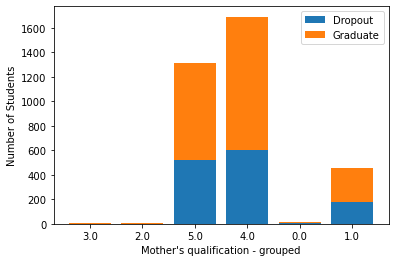

Target,Dropout,Graduate,pct graduate,pct dropout
Mother's qualification - grouped,,,,
0.0,2,1,0.333333,0.666667
1.0,2,1,0.333333,0.666667
2.0,522,790,0.602134,0.397866
3.0,600,1092,0.645390,0.354610
4.0,9,9,0.500000,0.500000
5.0,179,279,0.609170,0.390830


In [169]:
# removing nas
plot_temp, df_temp = provide_stacked_bar_individual("Mother's qualification - grouped", df_dropped.dropna())
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

Looks like its worth keeping - surprisingly, it peaks when the mother's highest education is secondary

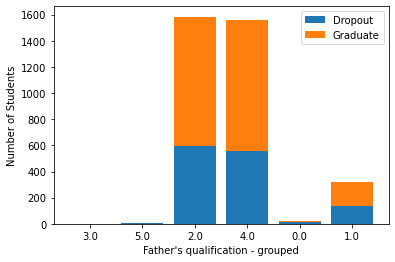

Target,Dropout,Graduate,pct graduate,pct dropout
Father's qualification - grouped,,,,
0.0,2,0,0.000000,1.000000
1.0,3,3,0.500000,0.500000
2.0,597,987,0.623106,0.376894
3.0,559,998,0.640976,0.359024
4.0,15,6,0.285714,0.714286
5.0,138,178,0.563291,0.436709


In [170]:
# removing nas
plot_temp, df_temp = provide_stacked_bar_individual("Father's qualification - grouped", df_dropped.dropna())
df_temp["pct graduate"] = df_temp["Graduate"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp["pct dropout"] = df_temp["Dropout"] / (df_temp["Dropout"] + df_temp["Graduate"])
df_temp

Similar sentiment about Father's. The thing is that, if we feed this into a model, it's hard to see a relationship. So, I would say, let's just change the education levels as categorical values

In [172]:
# Define a function to map the values for parent's qualification to broader categories
def categorize_parent_qualification_again(previous_qualification):
    post_second = {5, 44, 4, 43, 2, 3, 40}
    vocational = {22, 18, 39, 41, 42, 31, 33}
    secondary = {1, 9, 12, 10, 14, 19, 13, 20, 25}
    basic = {26, 11, 27, 29, 30, 38, 37}
    no_ed_lit = {36}
    no_ed = {35}


    # we're providing numbers as this can be ranked
    if previous_qualification in no_ed:
        return "No Education"
    elif previous_qualification in no_ed_lit:
        return "No Education - has literacy skills"
    elif previous_qualification in basic:
        return "Basic Level of Education"
    elif previous_qualification in secondary:
        return "Secondary Level of Education"
    elif previous_qualification in vocational:
        return "Vocational"
    elif previous_qualification in post_second:
        return "Post-Secondary"
    else:
        return None  # Returning None for unknowns

df_dropped["Mother's qualification - grouped"] = df_dropped["Mother's qualification"].apply(categorize_parent_qualification_again)
df_dropped["Father's qualification - grouped"] = df_dropped["Father's qualification"].apply(categorize_parent_qualification_again)
to_drop = ["Father's qualification", "Mother's qualification"]
df_dropped = df_dropped.drop(to_drop, axis=1)
df_dropped

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification (grade),Mother's occupation,Father's occupation,Admission grade,Displaced,...,Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,for_counting,Highest Education,Mother's qualification - grouped,Father's qualification - grouped
0,1,General Contigent,5,171,1,122.0,5,9,127.3,1,...,0.000000,0,10.8,1.4,1.74,Dropout,1,2,Secondary Level of Education,Secondary Level of Education
1,1,Mature Students,1,9254,1,160.0,3,3,142.5,1,...,13.666667,0,13.9,-0.3,0.79,Graduate,1,2,Secondary Level of Education,Post-Secondary
2,1,General Contigent,5,9070,1,122.0,9,9,124.8,1,...,0.000000,0,10.8,1.4,1.74,Dropout,1,2,Basic Level of Education,Basic Level of Education
3,1,General Contigent,2,9773,1,122.0,5,3,119.6,1,...,12.400000,0,9.4,-0.8,-3.12,Graduate,1,2,Basic Level of Education,Basic Level of Education
4,2,Mature Students,1,8014,0,100.0,9,9,141.5,0,...,13.000000,0,13.9,-0.3,0.79,Graduate,1,2,Basic Level of Education,Basic Level of Education
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,General Contigent,6,9773,1,125.0,5,4,122.2,0,...,12.666667,0,15.5,2.8,-4.06,Graduate,1,2,Secondary Level of Education,Secondary Level of Education
4420,1,General Contigent,2,9773,1,120.0,9,9,119.0,1,...,11.000000,0,11.1,0.6,2.02,Dropout,1,2,Secondary Level of Education,Secondary Level of Education
4421,1,General Contigent,1,9500,1,154.0,9,9,149.5,1,...,13.500000,0,13.9,-0.3,0.79,Dropout,1,2,Basic Level of Education,Basic Level of Education
4422,1,General Contigent,1,9147,1,180.0,7,4,153.8,1,...,12.000000,0,9.4,-0.8,-3.12,Graduate,1,2,Basic Level of Education,Basic Level of Education
